In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from joblib import load
from datetime import datetime

2025-10-24 14:05:30.274304: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 14:05:30.298292: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 14:05:30.444758: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 14:05:31.544799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 42
EPOCHS = 15
BATCH  = 32

tf.keras.utils.set_random_seed(SEED)

In [3]:
ARTIFACTS_DIR = "../artifacts"
MODEL_NAME = "cnn_baseline"

INPUT_FILE = os.path.join(ARTIFACTS_DIR, "images_tuple.joblib")

LOG_DIR   = os.path.join(ARTIFACTS_DIR, "logs", f"{MODEL_NAME}")
MODEL_FILE = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME}.keras")
CKPT_FILE  = os.path.join(ARTIFACTS_DIR, f"best_{MODEL_NAME}.keras")

In [4]:
(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    classes
) = load(INPUT_FILE)

num_classes = len(classes)
print("Classes:", classes)
print("Train shape:", X_train.shape, y_train.shape)

Classes: ['az', 'dobro', 'estb', 'frbtb', 'ize', 'jatb', 'ljudie', 'nasb', 'sa', 'sta', 'ukb', 'vede']
Train shape: (900, 128, 128, 4) (900, 12)


In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1.0 / 255),
    
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.summary()

2025-10-24 14:05:34.455214: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2025-10-24 14:05:34.470006: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2025-10-24 14:05:34.503290: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    14,745,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,766,124 (56.33 MB)

 Trainable params: 14,766,124 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/15


2025-10-24 14:05:34.866153: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 235929600 exceeds 10% of free system memory.
2025-10-24 14:05:35.708789: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - categorical_accuracy: 0.1941 - loss: 6.7645 - val_categorical_accuracy: 0.8140 - val_loss: 0.6236
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - categorical_accuracy: 0.8339 - loss: 0.5114 - val_categorical_accuracy: 0.8721 - val_loss: 0.3701
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - categorical_accuracy: 0.9621 - loss: 0.1185 - val_categorical_accuracy: 0.9109 - val_loss: 0.3159
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - categorical_accuracy: 0.9919 - loss: 0.0326 - val_categorical_accuracy: 0.9264 - val_loss: 0.2815
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - categorical_accuracy: 0.9971 - loss: 0.0154 - val_categorical_accuracy: 0.8915 - val_loss: 0.3922
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - categorical_accuracy: 0.9896 - loss: 0.0232 - val_categorical_accuracy: 0.9031 - val_loss: 0.3912
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - categorical_accuracy: 0.9928 - loss: 0.0260 -

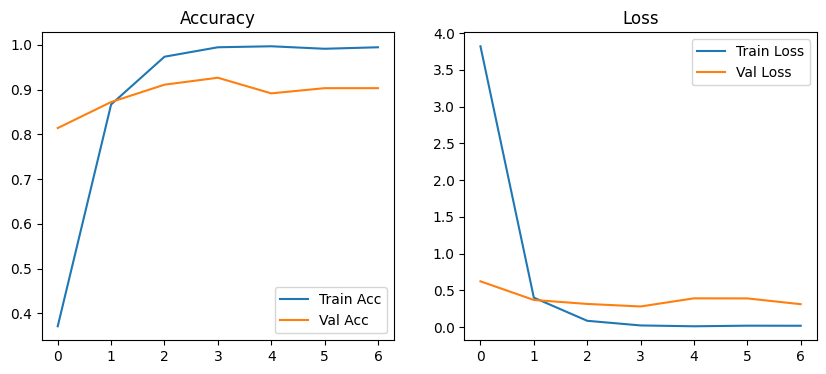

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [8]:
model.save(MODEL_FILE)
print(f"Saved model to {MODEL_FILE}")

Saved model to ../artifacts/cnn_baseline.keras
